In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise
import tensorflow as tf

from tqdm.notebook import tqdm
import random

In [ ]:
! pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
if 'SIDD_Small_sRGB_Only' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1qYmNt9Hbfu2bFbqvpUzAJ3jRfi1pF-ak
    # !gdown https://drive.google.com/uc?export=download&id=1INbrrubone4WwW_Q9PBwmeN_QapCwfLS
    get_ipython().system_raw('7z x SIDD_Small_sRGB_Only.zip -o/content/ && rm SIDD_Small_sRGB_Only.zip')

Downloading...
From: https://drive.google.com/uc?id=1qYmNt9Hbfu2bFbqvpUzAJ3jRfi1pF-ak
To: /content/SIDD_Small_sRGB_Only.zip
100% 6.62G/6.62G [01:49<00:00, 60.2MB/s]


In [ ]:
def get_images_paths(root_dir_ssid):
    # Getting SSID dataset images
    root = pathlib.Path(root_dir_ssid)
    img_paths = list(root.rglob("*.PNG*"))
    img_paths_lst = [str(path) for path in img_paths]

    gt_lst = []
    noisy_lst= []
    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-3]
        if img_type=="NOISY":
            noisy_lst.append(p)
        elif img_type=="GT":
            gt_lst.append(p)
    noisy_array = np.asarray(noisy_lst)
    gt_array = np.asarray(gt_lst)
    return noisy_array, gt_array

In [ ]:
from sklearn.model_selection import train_test_split

noisy_array_paths, gt_array_paths = get_images_paths("SIDD_Small_sRGB_Only")

noisy_train_paths, noisy_test_paths, gt_train_paths, gt_test_paths = train_test_split(noisy_array_paths, gt_array_paths, test_size=0.20, random_state=42)

In [ ]:
print(noisy_train_paths.shape)
print(noisy_test_paths.shape)
print(gt_train_paths.shape)
print(gt_test_paths.shape)

(128,)
(32,)
(128,)
(32,)


In [ ]:
# Get gt_images in memory
def get_images_in_mem(images_paths):
    images_lst = []
    for img_path in tqdm(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        images_lst.append(img)
    return np.array(images_lst)

In [ ]:
noisy_train_images = get_images_in_mem(noisy_train_paths)
noisy_test_images = get_images_in_mem(noisy_test_paths)

gt_train_images = get_images_in_mem(gt_train_paths)
gt_test_images = get_images_in_mem(gt_test_paths)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_test_images.shape)

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

(128, 256, 256, 3)
(32, 256, 256, 3)
(128, 256, 256, 3)
(32, 256, 256, 3)


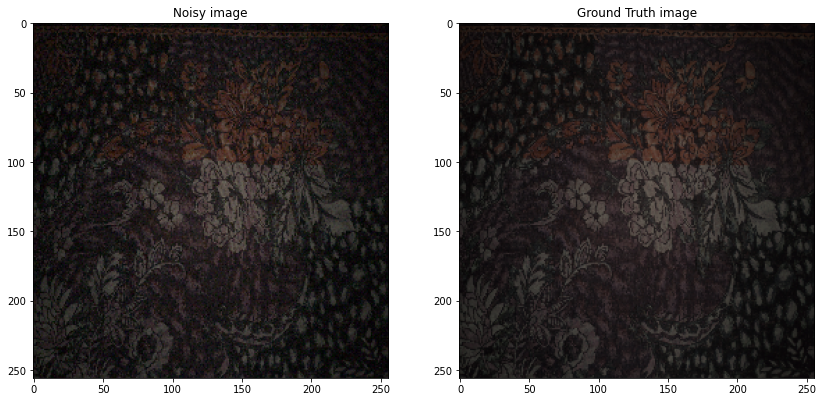

In [ ]:
f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(noisy_train_images[5])
axarr[0].set_title("Noisy image")
axarr[1].imshow(gt_train_images[5])
axarr[1].title.set_text("Ground Truth image")

In [ ]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def _hue(image, label):
    rand_value = random.uniform(-1,1)
    image = tf.image.adjust_hue(image, rand_value)
    label = tf.image.adjust_hue(label, rand_value)
    return image, label

def _brightness(image, label):
    rand_value = random.uniform(-0.08,0.25)
    image = tf.image.adjust_brightness(image, rand_value)
    label = tf.image.adjust_brightness(label, rand_value)
    return image, label

def _saturation(image, label):
    rand_value = random.uniform(1, 5)
    image = tf.image.adjust_saturation(image, rand_value)
    label = tf.image.adjust_saturation(label, rand_value)
    return image, label

def _contrast(image, label):
    rand_value = random.uniform(1, 3)
    image = tf.image.adjust_contrast(image, rand_value)
    label = tf.image.adjust_contrast(label, rand_value)
    return image, label

# What does batch, repeat, and shuffle do with TensorFlow Dataset?
# https://stackoverflow.com/q/53514495/7697658
def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def _hue(image, label):
    rand_value = random.uniform(-1,1)
    image = tf.image.adjust_hue(image, rand_value)
    label = tf.image.adjust_hue(label, rand_value)
    return image, label

def _brightness(image, label):
    rand_value = random.uniform(-0.08,0.25)
    image = tf.image.adjust_brightness(image, rand_value)
    label = tf.image.adjust_brightness(label, rand_value)
    return image, label

def _saturation(image, label):
    rand_value = random.uniform(1, 5)
    image = tf.image.adjust_saturation(image, rand_value)
    label = tf.image.adjust_saturation(label, rand_value)
    return image, label

def _contrast(image, label):
    rand_value = random.uniform(1, 3)
    image = tf.image.adjust_contrast(image, rand_value)
    label = tf.image.adjust_contrast(label, rand_value)
    return image, label

# What does batch, repeat, and shuffle do with TensorFlow Dataset?
# https://stackoverflow.com/q/53514495/7697658
def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=4
# augmentation_lst = [_up_down_flip, _left_right_flip, _rotate, _hue, _brightness, _saturation, _contrast]
augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=noisy_train_images, y=gt_train_images, batch_size=BATCH_SIZE, augmentations=augmentation_lst)
image_generator_test = tf_data_generator(X=noisy_test_images, y=gt_test_images, batch_size=BATCH_SIZE)

In [ ]:
image_generator_train

<PrefetchDataset element_spec=(TensorSpec(shape=(4, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(4, 256, 256, 3), dtype=tf.uint8, name=None))>

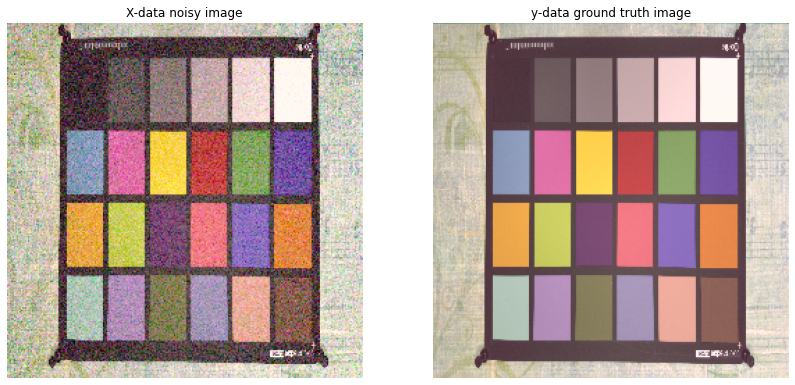

In [ ]:
# SANITY CHECK of the Dataset generator
for noisy, gt in image_generator_train.take(1):  # only take first element of dataset
    numpy_images = noisy.numpy()
    numpy_labels = gt.numpy()

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(numpy_images[1])
axarr[0].set_title("X-data noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(numpy_labels[1])
axarr[1].set_title("y-data ground truth image")
axarr[1].set_axis_off()

# NEWNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
class Convolutional_block(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_2 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_3 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_4 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')

    def call(self, X):
        X_1 = self.conv_1(X)
        X_1 = Activation('relu')(X_1)

        X_2 = self.conv_2(X_1)
        X_2 = Activation('relu')(X_2)

        X_3 = self.conv_3(X_2)
        X_3 = Activation('relu')(X_3)

        X_4 = self.conv_4(X_3)
        X_4 = Activation('relu')(X_4)
        
        #print('---conv block=',X_4.shape)
        
        return X_4

In [ ]:
class Channel_attention(tf.keras.layers.Layer):
    def __init__(self, C=64, **kwargs):
        super().__init__(**kwargs)
        self.C=C
        self.gap = GlobalAveragePooling2D()
        self.dense_middle = Dense(units=2, activation='relu')
        self.dense_sigmoid = Dense(units=self.C, activation='sigmoid')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        v = self.gap(X)
        #print("ca_ after gap =",v.shape)
        fc1 = self.dense_middle(v)
        #print("ca_ after fc1 =",fc1.shape)
        mu = self.dense_sigmoid(fc1)
        #print("ca_ after fc2 =",mu.shape)

        U_out = Multiply()([X, mu])
        
        #print('---channel attention block=',U_out.shape)

        return U_out

In [ ]:
def create_model():
    tf.keras.backend.clear_session()

    input = Input(shape=(256,256,3), name="input_layer")
    print("Input =",input.shape)
    conv_block = Convolutional_block()(input)
    print("Conv block =",conv_block.shape)
    ca_block = Channel_attention()(conv_block)
    print("Channel Attention =",ca_block.shape)
    ca_block = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ca_block)
    print("Channel Attention Last CNN =",ca_block.shape)
    # ca_block = Concatenate()([input, ca_block])
    # print("First phase =",ca_block.shape)
    print()

    # conv_layer_1 = Conv2D(filters=256, kernel_size=2, padding='same', name="conv_1")(ca_block)
    #conv_layer_2 = Conv2D(filters=256, kernel_size=2, padding='same', name="conv_2")(conv_layer_1)
    #conv_layer_3 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_3")(conv_layer_2)
    #conv_layer_4 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_4")(conv_layer_3)
    # conv_layer_5 = Conv2D(filters=128, kernel_size=3, padding='same', name="conv_5")(conv_layer_4)
    #conv_layer_5 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_5")(conv_layer_4)
    #conv_layer_6 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_6")(conv_layer_5)
    #conv_layer_7 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_7")(conv_layer_6)
    #conv_layer_8 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_8")(conv_layer_7)
    #conv_layer_9 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_9")(conv_layer_8)
    #conv_layer_10 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_10")(conv_layer_9)
    #conv_layer_11 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_11")(conv_layer_10)
    #conv_layer_12 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_12")(conv_layer_11)
    #conv_layer_13 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_13")(conv_layer_12)
    #conv_layer_14 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_14")(conv_layer_13)
    #conv_layer_15 = Conv2D(filters=128, kernel_size=3, padding='same', name="conv_15")(conv_layer_14)
    # conv_layer_9 = Conv2D(filters=128, kernel_size=3, padding='same', name="conv_9")(conv_layer_8)

    #deconv_layer_15 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_15")(conv_layer_15)
    #deconv_layer_15 = Add(name="add_1")([conv_layer_14, deconv_layer_15])
    #deconv_layer_14 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_14")(deconv_layer_15)
    #deconv_layer_13 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_13")(conv_layer_14)
    #deconv_layer_13 = Add(name="add_1")([conv_layer_12, deconv_layer_13])
    #deconv_layer_12 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_12")(deconv_layer_13)
    #deconv_layer_11 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_11")(conv_layer_12)
    #deconv_layer_11 = Add(name="add_1")([conv_layer_10, deconv_layer_11])
    #deconv_layer_10 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_10")(deconv_layer_11)
    #deconv_layer_9 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_9")(conv_layer_10)
    #deconv_layer_9 = Add(name="add_1")([conv_layer_8, deconv_layer_9])
    # deconv_layer_8 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_8")(deconv_layer_9)
    #deconv_layer_7 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_7")(conv_layer_8)
    #deconv_layer_7 = Add(name="add_2")([conv_layer_6, deconv_layer_7])
    #deconv_layer_6 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_6")(deconv_layer_7)
    #deconv_layer_5 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_5")(deconv_layer_6)
    #deconv_layer_5 = Add(name="add_3")([conv_layer_4, deconv_layer_5])
    #deconv_layer_4 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_4")(deconv_layer_5)
    #deconv_layer_3 = Conv2DTranspose(filters=256, kernel_size=3, padding='same', name="deconv_3")(deconv_layer_4)
    #deconv_layer_3 = Add(name="add_4")([conv_layer_2, deconv_layer_3])
    #deconv_layer_2 = Conv2DTranspose(filters=128, kernel_size=3, padding='same', name="deconv_2")(deconv_layer_3)
    #deconv_layer_1 = Conv2DTranspose(filters=3, kernel_size=3, padding='same', name="deconv_1")(deconv_layer_2)
    #out = Add(name="add_5")([input, deconv_layer_1])

    conv_layer_1 = Conv2D(filters=256, kernel_size=2, padding='same', name="conv_1")(ca_block)
    conv_layer_2 = Conv2D(filters=256, kernel_size=2, padding='same', name="conv_2")(conv_layer_1)
    conv_layer_3 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_3")(conv_layer_2)
    conv_layer_4 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_4")(conv_layer_3)
    conv_layer_5 = Conv2D(filters=128, kernel_size=3, padding='same', name="conv_5")(conv_layer_4)
   
    

    deconv_layer_5 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_5")(conv_layer_5)
    deconv_layer_5 = Add(name="add_1")([conv_layer_4, deconv_layer_5])
    deconv_layer_4 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_4")(deconv_layer_5)
    deconv_layer_3 = Conv2DTranspose(filters=256, kernel_size=3, padding='same', name="deconv_3")(deconv_layer_4)
    deconv_layer_3 = Add(name="add_2")([conv_layer_2, deconv_layer_3])
    deconv_layer_2 = Conv2DTranspose(filters=128, kernel_size=3, padding='same', name="deconv_2")(deconv_layer_3)
    deconv_layer_1 = Conv2DTranspose(filters=3, kernel_size=3, padding='same', name="deconv_1")(deconv_layer_2)
    out = Add(name="add_3")([input, deconv_layer_1])
    out = Add(name="add_3")([ca_block, deconv_layer_1])


    model = Model(inputs=[input], outputs=[out])
    return model

In [ ]:
model = create_model()
model.summary()

Input = (None, 256, 256, 3)
Conv block = (None, 256, 256, 64)
Channel Attention = (None, 256, 256, 64)
Channel Attention Last CNN = (None, 256, 256, 3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 convolutional_block (Convoluti  (None, 256, 256, 64  112576     ['input_layer[0][0]']            
 onal_block)                    )                                                                 
                                                                                                  
 channel_attention (Channel_att  (None, 

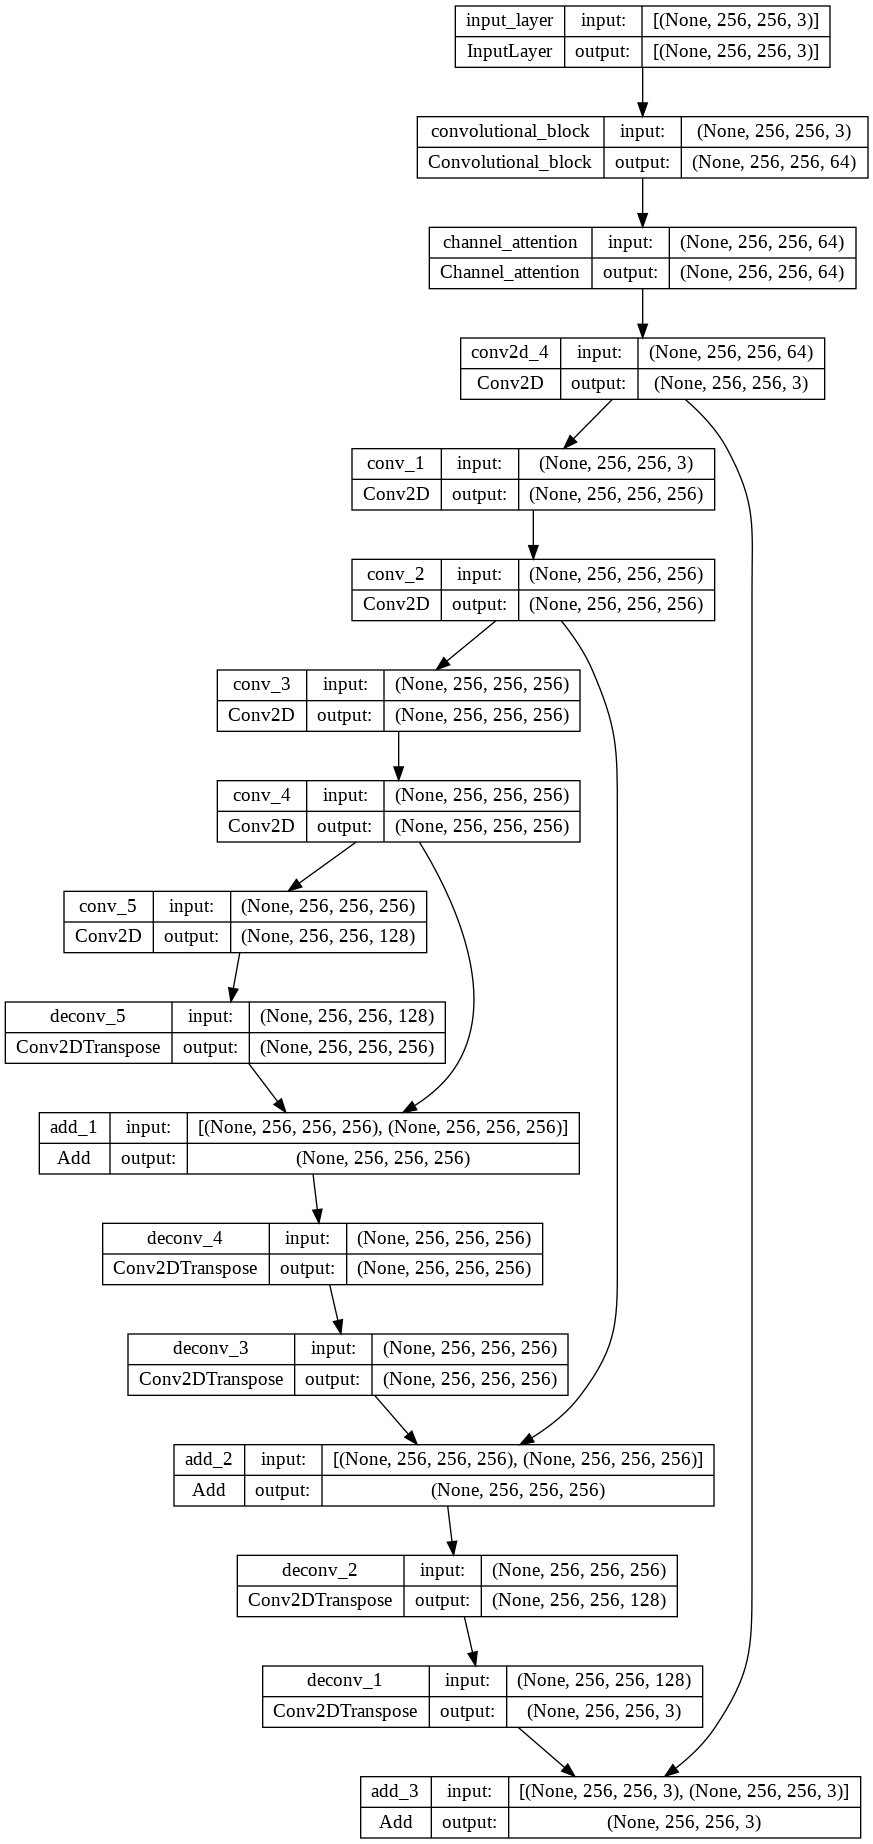

In [ ]:
tf.keras.utils.plot_model(model=model, to_file='model_plot.png', show_shapes=True)

#### **Training**

In [ ]:
steps_per_epoch_train = len(noisy_train_images)
steps_per_epoch_validation = len(noisy_test_images)

In [ ]:
best_models_path = "/content/drive/MyDrive/Colab Notebooks/COMP 576 Final Project/Best Models/baseline model_REDNet_channel_attention/"

callbacks_lst = [
    tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"best_REDNet_blindnoise_256x256.h5", period=10, save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10)
]

In [ ]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0001))
model.fit(image_generator_train, 
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        # epochs=200,
                        epochs=80,
                        verbose=1,
                        callbacks=callbacks_lst)

Epoch 1/80
128/128 [==============================] - 167s 1s/step - loss: 363.3554 - val_loss: 183.8594 - lr: 1.0000e-04
Epoch 2/80
128/128 [==============================] - 149s 1s/step - loss: 202.1580 - val_loss: 91.2720 - lr: 1.0000e-04
Epoch 3/80
128/128 [==============================] - 149s 1s/step - loss: 74.2323 - val_loss: 61.5904 - lr: 1.0000e-04
Epoch 4/80
128/128 [==============================] - 149s 1s/step - loss: 58.0327 - val_loss: 55.5896 - lr: 1.0000e-04
Epoch 5/80
128/128 [==============================] - 149s 1s/step - loss: 58.8492 - val_loss: 50.0600 - lr: 1.0000e-04
Epoch 6/80
128/128 [==============================] - 149s 1s/step - loss: 68.6765 - val_loss: 82.0851 - lr: 1.0000e-04
Epoch 7/80
128/128 [==============================] - 140s 1s/step - loss: 50.0931 - val_loss: 45.6986 - lr: 1.0000e-04
Epoch 8/80
128/128 [==============================] - 149s 1s/step - loss: 45.3412 - val_loss: 45.8614 - lr: 1.0000e-04
Epoch 9/80
128/128 [=================

In [ ]:
best_models_path = "/content/drive/MyDrive/Colab Notebooks/COMP 576 Final Project/Best Models/baseline model_REDNet_channel_attention/"
model.save(best_models_path+"best_REDNet_blindnoise_256x256.h5")

NameError: ignored

# Inference

In [ ]:
# Inference

def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)
    
    return predicted_image[0]

In [ ]:
def inference_batch_images(model, noisy_images):
    predicted_image = model.predict(noisy_images, batch_size=4)
    return predicted_image

In [ ]:
def visualize_predictions(model, X_test, y_test, n):
    random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    for i in random_numbers:
        noisy_image = X_test[i]
        gt_image = y_test[i]
        predicted_image = inference_single_image(model, X_test[i])
        predicted_image/=255

        f, axarr = plt.subplots(1,3, figsize=(21,21))
        axarr[0].imshow(noisy_image)
        axarr[0].set_title("Noisy image")
        axarr[0].set_axis_off()
        axarr[1].imshow(gt_image)
        axarr[1].set_title("Ground truth image")
        axarr[1].set_axis_off()
        axarr[2].imshow(predicted_image)
        axarr[2].set_title("Predicted image")
        axarr[2].set_axis_off()

In [ ]:
best_models_path = "/content/drive/MyDrive/Colab Notebooks/COMP 576 Final Project/Best Models/baseline model_REDNet_channel_attention/"

model = tf.keras.models.load_model(best_models_path+'best_REDNet_blindnoise_256x256.h5', custom_objects={'Convolutional_block': Convolutional_block,
                                                                                                        'Channel_attention':Channel_attention})


NameError: ignored

In [ ]:
visualize_predictions(model, noisy_test_images, gt_test_images, 10)

NameError: ignored

In [ ]:
# Test single image prediction

# banana = "NIND_banana_ISOH3.png"
# kibbles = "NIND_kibbles_ISOH3.png"
# library = "NIND_BruegelLibraryS1_NZ.png"
# parrots = "kodim23-noise-std51.png"
# GRB = "GRB.JPG"
eye = "eye_closeup_smaller_DIM25_noise_stddev_51.png"

img_path = "/content/drive/MyDrive/Colab Notebooks/COMP 576 Final Project/"+eye

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

predicted_image = inference_single_image(model, img)
predicted_image/=255

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(img)
axarr[0].title.set_text("Noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(predicted_image)
axarr[1].title.set_text("Predicted image")
axarr[1].set_axis_off()

NameError: ignored

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images.shape[0]
psnr_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images.shape[0]
ssim_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)